<a href="https://colab.research.google.com/github/RaisaAnika/model-confidence_CIFAR10/blob/main/CIS545_Fall22_ModelConfidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Model and Some Useful Starter Code

This starter code is to help you have a CIFAR-10 model that is trained on the whole dataset. You will also find some helper functions for splitting the dataset into $n$ disjoint sets (from which you can train individual models that will serve in the ensemble).

The CIFAR10 dataset contains 60K color images in 10 classes, with 6K images in each class. The dataset is divided into 50K training images and 10K testing images. The classes are mutually exclusive and there is no overlap between them. The 10 classes are ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'].




In [1]:
!pip install tensorflow_privacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 301 kB 6.3 MB/s 
     |████████████████████████████████| 60 kB 4.2 MB/s 
     |████████████████████████████████| 9.4 MB 12.9 MB/s 
     |████████████████████████████████| 5.7 MB 21.7 MB/s 
     |████████████████████████████████| 89 kB 2.6 MB/s 
     |████████████████████████████████| 12.2 MB 26.9 MB/s 
     |████████████████████████████████| 126 kB 53.6 MB/s 
     |████████████████████████████████| 295 kB 9.5 MB/s 
     |████████████████████████████████| 965 kB 9.9 MB/s 
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.3.0
    Uninstalling absl-py-1.3.0:
      Successfully uninstalled absl-py-1.3.0
  Attempting uninstall: attrs
    Found existing installation: attrs 22.1.0
    Uninstalling attrs-22.1.0:
      Successfully uninstalled attrs-22.1.0
  Attempting uninstall: tensorflow-probability
    Found existing installation

In [2]:
!pip install tensorflow-privacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Library Imports

In [3]:
import tensorflow as tf
from keras.models import Model   
from keras.layers import *
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.models import Sequential


import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, \
Dense, Input, Activation, MaxPool2D
from tensorflow.keras import Model

import sklearn.metrics

from numpy.random import default_rng
rng = default_rng()
AUTO = tf.data.AUTOTUNE

In [5]:
###Tensorflow attack libraries

from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack as mia 
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType

/usr/local/lib/python3.8/dist-packages/tensorflow_privacy/privacy/membership_inference_attack/__init__.py:18: UserWarning: 
Membership inference attack sources were moved. Please replace
import tensorflow_privacy.privacy.membership_inference_attack

with
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
  warnings.warn(


# Load Dataset - CIFAR 10

In [6]:
# download CIFAR-10 dataset and split it into train and test set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


170498071/170498071 [==============================] - 4s 0us/step


In [7]:
print(x_train.shape[0])

50000


In [8]:
print(x_test.shape[0])

10000


In [9]:
print(y_train)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [10]:
# normalze pixel values to be in the range [0,1] instead of [0, 255]
x_train, x_test= x_train/ 255.0, x_test / 255.0



In [11]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 6.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-privacy 0.8.7 requires matplotlib~=3.3, but you have matplotlib 3.1.3 which is incompatible.


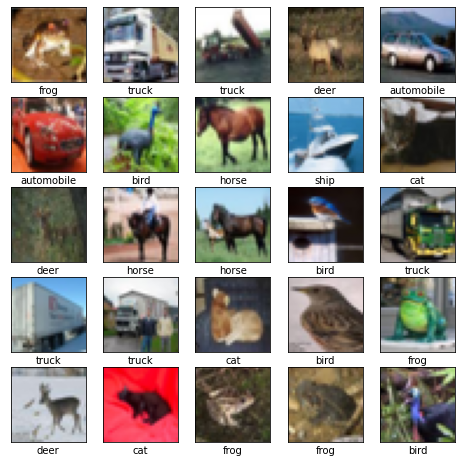

In [12]:
# let's check what individual samples in the training data look like just for verification

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(labels[y_train[i][0]])
plt.show()



# Machine Learning Model

In [13]:
def define_model():
  """ This model is fairly simple, feel free to play with this part in pursuit of a better accuracy architecture.
  """
  shape = (32, 32, 3)
  input = Input(shape=shape)
  x = Conv2D(32, (3, 3), activation='relu')(input)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dense(10)(x)
  model = Model(input, x)
  return model

In [14]:
model = define_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

In [15]:
# def AlexnetModel(input_shape,num_classes):
#     model = Sequential()
# # model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
# # for original Alexnet
#     model.add(Conv2D(48, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=input_shape))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
# # Local Response normalization for Original Alexnet
#     model.add(BatchNormalization())

#     model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# # Local Response normalization for Original Alexnet
#     model.add(BatchNormalization())

#     model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
#     model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
#     model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# # Local Response normalization for Original Alexnet
#     model.add(BatchNormalization())

#     model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model

In [16]:
# shape = (32, 32, 3)
# num_class=10
# learning_rate=.01
#   # epochs=60
#   # M=5

In [17]:
# model1 = AlexnetModel(shape,num_class)
# model1.summary()

In [18]:
# check model summary
model = define_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          3692

# Generating Subset of the Dataset

In [19]:
##divide xtrain n ytrain to 5 DISJOINT subsets
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical


M=5 ##defining the desired no. of subsets

X=x_train
Y=y_train
for i in range(0,M):
  K=M-i
  if(K>=2):
    train=X
    test=Y
    skf = StratifiedKFold(n_splits=K)
    skf.get_n_splits(X, Y)
    #print(skf)
    for train_index, test_index in skf.split(X, Y):
       #print(X.shape)
       X,globals()['x_train_split%s' % i]=train[train_index], train[test_index]
       Y,globals()['trainy_split%s' % i]=test[train_index], test[test_index]
       y_hot=globals()['trainy_split%s' % i]
       y_hot=to_categorical(y_hot)
       globals()['y_train_split%s' % i]=y_hot
       #X=train
       #Y=test
  elif K==1:
    globals()['x_train_split%s' % i]=X
    globals()['trainy_split%s' % i]=Y
    y_hot=to_categorical(Y)
    globals()['y_train_split%s' % i]=y_hot

In [20]:
## 5 disjoint set of the train data
d1_data = x_train_split0
d1_label = trainy_split0
d2_data= x_train_split1
d2_label=trainy_split1
d3_data= x_train_split2
d3_label=trainy_split2
d4_data= x_train_split3
d4_label=trainy_split3
d5_data= x_train_split4
d5_label=trainy_split4

In [21]:
d1_data.shape

(10000, 32, 32, 3)

In [22]:
d1_label.shape

(10000, 1)

In [23]:
skf.split(X, Y)

<generator object _BaseKFold.split at 0x7fdf091d80b0>

# Model Tuning

In [24]:
# specify parameters for model
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])



In [25]:
# # specify parameters for model1
# optimizer = tf.keras.optimizers.Adam()
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # compile the model1
# model1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Model Training on subset 1

In [26]:
## fitting d1

# train the model with d1
history = model.fit(d1_data, d1_label,
                       validation_data=(x_test, y_test),
                       batch_size=128, 
                       epochs=5)
history

Epoch 1/5
79/79 [==============================] - 28s 334ms/step - loss: 2.0897 - accuracy: 0.2222 - val_loss: 1.8763 - val_accuracy: 0.3167
Epoch 2/5
79/79 [==============================] - 15s 189ms/step - loss: 1.7613 - accuracy: 0.3468 - val_loss: 1.8542 - val_accuracy: 0.3470
Epoch 3/5
79/79 [==============================] - 15s 189ms/step - loss: 1.6614 - accuracy: 0.3913 - val_loss: 1.5980 - val_accuracy: 0.4147
Epoch 4/5
79/79 [==============================] - 15s 191ms/step - loss: 1.5135 - accuracy: 0.4498 - val_loss: 1.5528 - val_accuracy: 0.4389
Epoch 5/5
79/79 [==============================] - 15s 190ms/step - loss: 1.4527 - accuracy: 0.4729 - val_loss: 1.4217 - val_accuracy: 0.4833


## Model Training on subset 2

In [27]:
## fitting d2

# train the model with d2
history2 = model.fit(d2_data, d2_label,
                       validation_data=(x_test, y_test),
                       batch_size=128, 
                       epochs=5)
history2

Epoch 1/5
79/79 [==============================] - 15s 194ms/step - loss: 1.4243 - accuracy: 0.4853 - val_loss: 1.3879 - val_accuracy: 0.5053
Epoch 2/5
79/79 [==============================] - 17s 214ms/step - loss: 1.3781 - accuracy: 0.5071 - val_loss: 1.3288 - val_accuracy: 0.5227
Epoch 3/5
79/79 [==============================] - 15s 192ms/step - loss: 1.3157 - accuracy: 0.5278 - val_loss: 1.3352 - val_accuracy: 0.5246
Epoch 4/5
79/79 [==============================] - 15s 191ms/step - loss: 1.2670 - accuracy: 0.5493 - val_loss: 1.3328 - val_accuracy: 0.5250
Epoch 5/5
79/79 [==============================] - 15s 192ms/step - loss: 1.2444 - accuracy: 0.5585 - val_loss: 1.2580 - val_accuracy: 0.5498


## Model Training on subset 3

In [28]:
## fitting d3

# train the model with d3
history3 = model.fit(d3_data, d3_label,
                       validation_data=(x_test, y_test),
                       batch_size=128, 
                       epochs=5)
history3

Epoch 1/5
79/79 [==============================] - 18s 229ms/step - loss: 1.2514 - accuracy: 0.5570 - val_loss: 1.2644 - val_accuracy: 0.5484
Epoch 2/5
79/79 [==============================] - 15s 190ms/step - loss: 1.1965 - accuracy: 0.5715 - val_loss: 1.2165 - val_accuracy: 0.5682
Epoch 3/5
79/79 [==============================] - 15s 191ms/step - loss: 1.1484 - accuracy: 0.5971 - val_loss: 1.2091 - val_accuracy: 0.5759
Epoch 4/5
79/79 [==============================] - 16s 205ms/step - loss: 1.1079 - accuracy: 0.6087 - val_loss: 1.1768 - val_accuracy: 0.5831
Epoch 5/5
79/79 [==============================] - 15s 191ms/step - loss: 1.0797 - accuracy: 0.6210 - val_loss: 1.1797 - val_accuracy: 0.5834


## Model Training on subset 4

In [29]:
## fitting d4

# train the model with d4
history4 = model.fit(d4_data, d4_label,
                       validation_data=(x_test, y_test),
                       batch_size=128, 
                       epochs=5)
history4

Epoch 1/5
79/79 [==============================] - 15s 195ms/step - loss: 1.1926 - accuracy: 0.5769 - val_loss: 1.1190 - val_accuracy: 0.6063
Epoch 2/5
79/79 [==============================] - 15s 191ms/step - loss: 1.1141 - accuracy: 0.6098 - val_loss: 1.2400 - val_accuracy: 0.5629
Epoch 3/5
79/79 [==============================] - 15s 189ms/step - loss: 1.0804 - accuracy: 0.6239 - val_loss: 1.1169 - val_accuracy: 0.6076
Epoch 4/5
79/79 [==============================] - 15s 191ms/step - loss: 1.0534 - accuracy: 0.6314 - val_loss: 1.0992 - val_accuracy: 0.6139
Epoch 5/5
79/79 [==============================] - 15s 189ms/step - loss: 0.9996 - accuracy: 0.6504 - val_loss: 1.1490 - val_accuracy: 0.5971


## Model Training on subset 5

In [30]:
## fitting d5

# train the model with d4
history5 = model.fit(d5_data, d5_label,
                       validation_data=(x_test, y_test),
                       batch_size=128, 
                       epochs=5)
history5

Epoch 1/5
79/79 [==============================] - 15s 197ms/step - loss: 1.1130 - accuracy: 0.6062 - val_loss: 1.0947 - val_accuracy: 0.6190
Epoch 2/5
79/79 [==============================] - 16s 197ms/step - loss: 1.0331 - accuracy: 0.6368 - val_loss: 1.0804 - val_accuracy: 0.6237
Epoch 3/5
79/79 [==============================] - 16s 199ms/step - loss: 0.9836 - accuracy: 0.6569 - val_loss: 1.1046 - val_accuracy: 0.6176
Epoch 4/5
79/79 [==============================] - 16s 197ms/step - loss: 0.9658 - accuracy: 0.6657 - val_loss: 1.0411 - val_accuracy: 0.6338
Epoch 5/5
79/79 [==============================] - 16s 197ms/step - loss: 0.9104 - accuracy: 0.6808 - val_loss: 1.0996 - val_accuracy: 0.6204


# Plot Model Evaluation

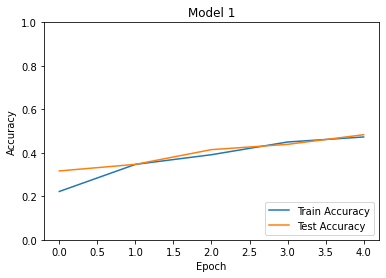

In [31]:
# evalaute model accuracy for d1
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title("Model 1")
plt.legend(loc='lower right')

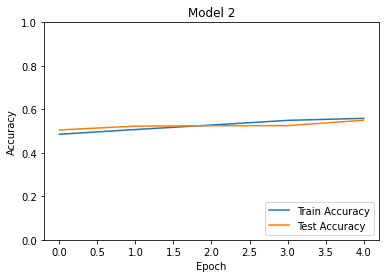

In [32]:
# evalaute model2 accuracy
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title("Model 2")
plt.legend(loc='lower right')

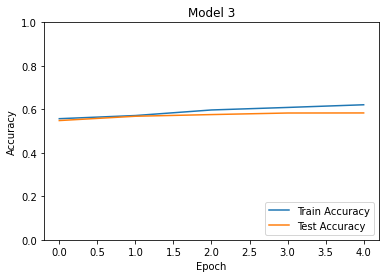

In [33]:
# evalaute model3 accuracy
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title("Model 3")
plt.legend(loc='lower right')

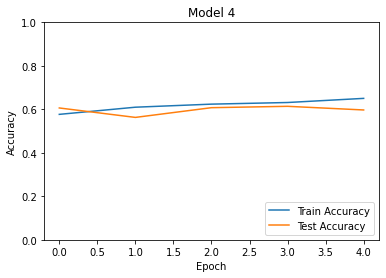

In [34]:
# evalaute model4 accuracy
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title("Model 4")
plt.legend(loc='lower right')

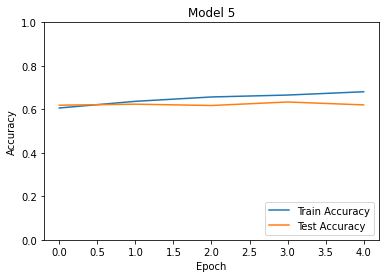

In [35]:
# evalaute model5 accuracy
plt.plot(history5.history['accuracy'], label='Train Accuracy')
plt.plot(history5.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title("Model 5")
plt.legend(loc='lower right')

# Generating Prediction Vector for member subset 1

In [36]:
print('Predict on train...')
logits_train1 = model.predict(d1_data)
print('Predict on test...')
logits_test1 = model.predict(x_test)

print('Apply softmax to get probabilities from logits...')
prob_train1 = tf.nn.softmax(logits_train1, axis=-1)
prob_test1 = tf.nn.softmax(logits_test1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_onehot = to_categorical(d1_label)
y_test_onehot = to_categorical(y_test)

loss_train1 = cce(constant(y_train_onehot), constant(prob_train1), from_logits=False).numpy()
loss_test1 = cce(constant(y_test_onehot), constant(prob_test1), from_logits=False).numpy()

index1 = 0
for p in logits_train1:
  print( p, np.argmax(p),y_test[index1])
  index1+=1

Streaming output truncated to the last 5000 lines.
[-2.114794   -5.303759    1.277766    1.3778603   2.6344838   0.8342901
  0.27360824  0.9512988  -3.0157232  -4.0946665 ] 4 [7]
[-0.40256923  2.3851392  -2.8262992  -1.5090873  -2.1431177  -2.3498893
 -5.4469514  -1.9754169   0.7178298   5.2994204 ] 9 [8]
[-1.0807226   0.01594145  0.6220579  -0.03400628  0.12952673  0.44242352
 -1.6047493   4.2189417  -2.6481159  -0.4265664 ] 7 [1]
[-1.748927   -4.683397   -0.01059426  2.8591597  -0.51083934  3.053857
 -1.6355205   1.2458137  -3.2565339  -2.019502  ] 5 [2]
[ 0.05994901 -1.8904845   0.42414337  1.7460563  -0.7393121  -0.3392444
 -0.30424082 -1.9420562  -0.22888792 -0.77409756] 3 [3]
[ 2.9351883  11.667291   -1.7633547  -2.0697675  -5.407722   -3.611293
 -3.20764    -2.0324836   0.35838085  4.4866495 ] 1 [2]
[ 6.9190955   3.183196   -1.2000167  -1.729383    0.42287832 -4.366335
 -4.854827   -2.68808     3.465534   -0.85302186] 0 [4]
[ 0.6005291  4.5942802 -2.5894895 -1.8894632 -1.9375273

# Generating Prediction Vector for member subset 2

In [37]:
print('Predict on train...')
logits_train2 = model.predict(d2_data)
print('Predict on test...')
logits_test2 = model.predict(x_test)

print('Apply softmax to get probabilities from logits...')
prob_train2 = tf.nn.softmax(logits_train2, axis=-1)
prob_test2 = tf.nn.softmax(logits_test2)

# print('Compute losses...')
# cce = tf.keras.backend.categorical_crossentropy
# constant = tf.keras.backend.constant

y_train_secondhot = to_categorical(d2_label)
y_test_secondhot = to_categorical(y_test)

loss_train2 = cce(constant(y_train_secondhot), constant(prob_train2), from_logits=False).numpy()
loss_test2 = cce(constant(y_test_secondhot), constant(prob_test2), from_logits=False).numpy()

index1 = 0
for p in logits_train2:
  print( p, np.argmax(p),y_test[index1])
  index1+=1

Streaming output truncated to the last 5000 lines.
[-3.3500714  -2.8149965   0.6501682  -0.05256578  3.24792     0.69494313
  0.9860611  -1.0782089  -1.7558237  -2.2474744 ] 4 [8]
[-1.9895412   1.1699861  -3.9149308  -1.5988519  -6.7157025   0.29087648
 -7.2467904  -1.670984    7.983904    6.711762  ] 8 [1]
[ 6.3997736   2.467839    1.3864651  -1.8058136  -0.13338853 -4.4382715
 -6.66243    -2.4083977   3.2710373  -2.341701  ] 0 [2]
[-3.0394175  -2.888846    0.8974499   1.9501305  -0.16837989 -0.20051622
  4.053888   -1.9755464  -0.38419032 -2.7810693 ] 6 [3]
[ 3.4280121   3.3465438  -2.625485    1.0088797  -2.4152606  -0.30859345
 -1.7997856  -0.34150216  2.8411775   0.89388037] 0 [2]
[-2.7978597  -1.0734806  -2.7966049  -0.68960214  1.2680681  -0.77472764
 -2.7715693   4.23229    -2.105719    1.0912837 ] 7 [4]
[-0.4786832   2.8658934  -2.842988    2.9759586   0.17592493  0.8789848
 -5.026778    0.25894257  3.065927   -3.0669158 ] 8 [2]
[ 4.452794    3.6576598   0.39495546 -1.9403129 

# Generating Prediction Vector for member subset 3

In [38]:
print('Predict on train...')
logits_train3 = model.predict(d3_data)
print('Predict on test...')
logits_test3 = model.predict(x_test)

print('Apply softmax to get probabilities from logits...')
prob_train3 = tf.nn.softmax(logits_train3, axis=-1)
prob_test3 = tf.nn.softmax(logits_test3)

# print('Compute losses...')
# cce = tf.keras.backend.categorical_crossentropy
# constant = tf.keras.backend.constant

y_train_thirdhot = to_categorical(d3_label)
y_test_thirdhot = to_categorical(y_test)

loss_train3 = cce(constant(y_train_thirdhot), constant(prob_train3), from_logits=False).numpy()
loss_test3 = cce(constant(y_test_thirdhot), constant(prob_test3), from_logits=False).numpy()

index1 = 0
for p in logits_train3:
  print( p, np.argmax(p),y_test[index1])
  index1+=1

Streaming output truncated to the last 5000 lines.
  0.78129137  1.7977915  -2.6419084  -3.227723  ] 4 [2]
[-2.2756383   0.34658727 -0.56046206  1.5219975   1.8275465   0.8027156
  0.12057959 -1.0206003  -1.1848974  -1.8159655 ] 4 [3]
[-2.6679409   0.4859775  -1.323339    0.07678592  1.2230636   0.04492354
  0.51657766  0.35215482 -4.1221976   1.0218284 ] 4 [2]
[-0.969092  -2.7534528 -0.9030784  2.4365845 -1.3417575  2.4550648
 -3.5592    -1.4928595 -3.252759   0.047148 ] 5 [4]
[ 0.1720055  -0.07727366  1.9127103  -0.11057344  4.4348655  -0.2679859
 -1.7372807   2.0360708  -3.6086915  -4.532081  ] 4 [2]
[ 5.5726786  2.196921  -1.1529882 -2.5948346 -3.3853328 -3.670735
 -2.419928  -1.5437957  2.0886202  3.4893718] 0 [9]
[ 0.5711123   0.24458085 -1.7492319  -2.464466   -1.8692421  -2.4598906
 -7.427154    1.105292    0.9367284   5.9556656 ] 9 [0]
[ 2.0364852  -1.3994917   0.11587238 -0.93485284  0.07685253 -1.3146445
 -1.5556544  -1.8482022   4.4500937  -0.23631597] 8 [3]
[-0.21191864 -0

# Generating Prediction Vector for member subset 4

In [39]:
print('Predict on train...')
logits_train4 = model.predict(d4_data)
print('Predict on test...')
logits_test4 = model.predict(x_test)

print('Apply softmax to get probabilities from logits...')
prob_train4 = tf.nn.softmax(logits_train4, axis=-1)
prob_test4 = tf.nn.softmax(logits_test4)

# print('Compute losses...')
# cce = tf.keras.backend.categorical_crossentropy
# constant = tf.keras.backend.constant

y_train_forthhot = to_categorical(d4_label)
y_test_forthhot = to_categorical(y_test)

loss_train4 = cce(constant(y_train_forthhot), constant(prob_train4), from_logits=False).numpy()
loss_test4 = cce(constant(y_test_forthhot), constant(prob_test4), from_logits=False).numpy()

index1 = 0
for p in logits_train4:
  print( p, np.argmax(p),y_test[index1])
  index1+=1

Streaming output truncated to the last 5000 lines.
  0.45549518  0.64042026 -0.29026383 -1.019921  ] 3 [9]
[-1.2463288 -2.9581134 -1.3090829 -0.8287126  5.9955163  2.0890048
 -1.7788737  3.3228118 -4.226933  -2.722446 ] 4 [0]
[ 7.6279488   0.11081018  2.4934335  -1.276253   -0.39278102 -2.3114948
 -2.9120233  -4.9594154   2.0889769  -3.3424895 ] 0 [7]
[-0.7239523   5.7950907  -3.653987   -1.7460554  -1.1608318  -2.40505
 -0.84238327  1.2142334  -0.24914956  2.0827055 ] 1 [8]
[ 4.066283   1.2379764 -2.0488489  0.2041699 -2.3489745 -2.2632456
 -2.225764  -2.3491235  7.2800636 -0.3929683] 8 [1]
[ 3.645682    2.1615946   0.24766164  0.30917588 -0.42185497 -1.5725106
  0.0362962  -4.490189    0.7359752   0.37336546] 0 [2]
[-2.072832   -1.8811704   0.2704311   1.0408188   2.6487606   2.0847301
 -0.62306046  1.2171831  -2.5696661  -3.005121  ] 4 [3]
[ 2.630791    0.42346022 -0.54847    -0.9206768  -0.20496888 -3.4359047
 -2.4977243  -1.4446685   5.0160136  -0.12654582] 8 [2]
[ 3.0712686   0.8

# Generating Prediction Vector for member subset 5

In [40]:
print('Predict on train...')
logits_train5 = model.predict(d5_data)
print('Predict on test...')
logits_test5 = model.predict(x_test)

print('Apply softmax to get probabilities from logits...')
prob_train5 = tf.nn.softmax(logits_train5, axis=-1)
prob_test5 = tf.nn.softmax(logits_test5)

# print('Compute losses...')
# cce = tf.keras.backend.categorical_crossentropy
# constant = tf.keras.backend.constant

y_train_fifthhot = to_categorical(d5_label)
y_test_fifthhot = to_categorical(y_test)

loss_train5 = cce(constant(y_train_fifthhot), constant(prob_train5), from_logits=False).numpy()
loss_test5 = cce(constant(y_test_fifthhot), constant(prob_test5), from_logits=False).numpy()

index1 = 0
for p in logits_train5:
  print( p, np.argmax(p),y_test[index1])
  index1+=1

Streaming output truncated to the last 5000 lines.
 -0.8413856  -3.9353461   1.0501684  -2.163112  ] 0 [3]
[-5.579936   -3.8864686  -0.40652788  2.3533661  -2.9621336   5.88345
 -0.17974773  2.8191051  -3.861354   -2.130226  ] 5 [8]
[ 1.7517093  -4.5850954   0.8263682   2.7816176  -1.0226169   1.756307
  1.7745643  -1.7593714  -0.73516226 -3.3262296 ] 3 [0]
[-1.8351831  -0.23206459 -2.482726    0.007726    0.28752726  0.2324804
 -4.3227777   1.9752474  -1.960668    2.9249382 ] 9 [9]
[-2.9634564   1.4592533  -2.4764092   0.56486315 -5.89644     0.8107685
 -1.4057308  -0.7737926  -0.95917994  5.3914824 ] 9 [0]
[ 5.5918074  -2.0599866   0.538459   -0.6733278  -0.18184529 -3.0272598
 -2.2059512  -1.9786557   4.3417597  -1.3282274 ] 0 [7]
[ 1.2634965  -3.0891972  -0.6383312   1.493807   -0.73412097  0.6001242
 -0.8109914  -0.7150845   1.5568002  -2.2118564 ] 8 [8]
[-1.0106468  -0.7400564  -0.9068643   1.7384145   1.3868889   1.3438001
  4.218446   -0.39742154 -5.743577   -1.2898402 ] 6 [1]


In [41]:
!pip install tensorflow-model-remediation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 142 kB 6.8 MB/s 


# ATTACK on Subset 1 - Threshold attack:



In [42]:
# define what variables our attacker should have access to

attack_input1 = AttackInputData(
  logits_train = logits_train1,
  logits_test = logits_test1,
  loss_train = loss_train1,
  loss_test = loss_test1,
  labels_train = d1_label.reshape(d1_label.shape[0]),
  labels_test = y_test.reshape(y_test.shape[0],)
) 

In [43]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
by_classification_correctness = True)

In [44]:
#defining the attack type
attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
] 

In [45]:
attacks_result1 = mia.run_attacks(attack_input=attack_input1,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

In [46]:
attacks_result1.summary

<bound method AttackResults.summary of AttackResults(single_attack_results=[SingleAttackResult(slice_spec=SingleSliceSpec(feature=None, value=None), data_size=DataSize(ntrain=10000, ntest=10000), attack_type=<AttackType.THRESHOLD_ATTACK: 'threshold'>, roc_curve=RocCurve(thresholds=array([1.2166632e+01, 1.1166632e+01, 1.0921300e+01, ..., 5.0307583e-05,
       1.6570228e-05, 9.3579729e-06], dtype=float32), tpr=array([0.000e+00, 0.000e+00, 1.000e-04, ..., 9.998e-01, 1.000e+00,
       1.000e+00]), fpr=array([0.000e+00, 1.000e-04, 1.000e-04, ..., 9.999e-01, 9.999e-01,
       1.000e+00]), test_train_ratio=1.0), membership_scores_train=array([2.4640877, 2.562771 , 2.831749 , ..., 0.4467463, 0.6785407,
       0.5839511], dtype=float32), membership_scores_test=array([1.0826368 , 1.1125107 , 0.08052194, ..., 0.18976137, 0.2731344 ,
       0.07503822], dtype=float32)), SingleAttackResult(slice_spec=SingleSliceSpec(feature=None, value=None), data_size=DataSize(ntrain=10000, ntest=10000), attack_ty

# Validate attack results of subset 1



In [47]:

attacks_result1.summary()

'Best-performing attacks over all slices\n  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.52 on slice CLASS=3\n  THRESHOLD_ATTACK (with 1000 training and 1000 test examples) achieved an advantage of 0.05 on slice CLASS=5\n  THRESHOLD_ATTACK (with 1000 training and 1000 test examples) achieved a positive predictive value of 1.00 on slice CLASS=0'

In [48]:
attacks_result1.summary(by_slices = True)

'Best-performing attacks over all slices\n  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.52 on slice CLASS=3\n  THRESHOLD_ATTACK (with 1000 training and 1000 test examples) achieved an advantage of 0.05 on slice CLASS=5\n  THRESHOLD_ATTACK (with 1000 training and 1000 test examples) achieved a positive predictive value of 1.00 on slice CLASS=0\n\nBest-performing attacks over slice: "Entire dataset"\n  THRESHOLD_ATTACK (with 10000 training and 10000 test examples) achieved an AUC of 0.50\n  THRESHOLD_ATTACK (with 10000 training and 10000 test examples) achieved an advantage of 0.01\n  LOGISTIC_REGRESSION (with 10000 training and 10000 test examples) achieved a positive predictive value of 0.63\n\nBest-performing attacks over slice: "CLASS=0"\n  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.52\n  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.04\n  THRESHOLD_ATTACK (

#### Plotting the attack result to visualize the accuracy

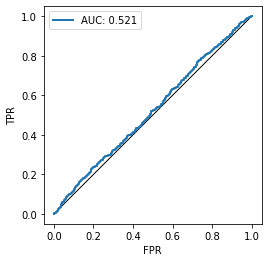

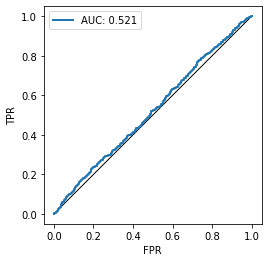

In [49]:
import tensorflow_privacy.privacy.membership_inference_attack.plotting as miaplt
miaplt.plot_roc_curve(attacks_result1.get_result_with_max_auc().roc_curve)

# Attack on Subset 1 - MLP Attack





In [50]:
###  define what variables our attacker should have access to

attack_inputp1 = AttackInputData(
  logits_train = logits_train1,
  logits_test = logits_test1,
  labels_train = d1_label.reshape(d1_label.shape[0]),
  labels_test = y_test.reshape(y_test.shape[0],)
) 

In [51]:
## the data slicing is kept same as during threshold attack
#defining the attack type
attack_types2 = [
    AttackType.MULTI_LAYERED_PERCEPTRON
] 

In [52]:
attacks_resultp1 = mia.run_attacks(attack_input=attack_inputp1,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types2)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [53]:
attacks_resultp1.summary()

'Best-performing attacks over all slices\n  MULTI_LAYERED_PERCEPTRON (with 1000 training and 1000 test examples) achieved an AUC of 0.51 on slice CLASS=7\n  MULTI_LAYERED_PERCEPTRON (with 1000 training and 1000 test examples) achieved an advantage of 0.08 on slice CLASS=6\n  MULTI_LAYERED_PERCEPTRON (with 1000 training and 1000 test examples) achieved a positive predictive value of 1.00 on slice CLASS=4'

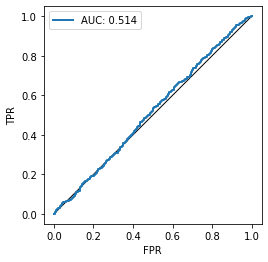

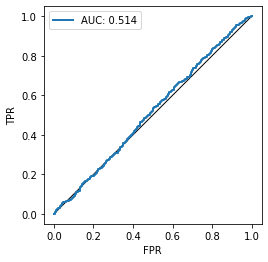

In [54]:
miaplt.plot_roc_curve(attacks_resultp1.get_result_with_max_auc().roc_curve)

# ***Confidence Exclusion***

### Capture the highest confidence value - subset1




In [55]:
### List for model probabilities
# 1- For our prediction verctors, we need to find the index with the highest confidence ( for all of them in that vector )
# 2- Once we have results, we will take them all within one list and figure out the highest value in that list

### subset 4 / capture highest confidence value
max_confident_value_1 = max(map(max, logits_train1))
print(max_confident_value_1)


14.4604025


### Capture the highest confidence value - subset2






In [73]:
# m = list(map(max, logits_train1))
# sorted(m,reverse=True)




In [56]:
### subset 2 / capture highest confidence value

max_confident_value_2 = max(map(max, logits_train2))
print(max_confident_value_2)


15.633828


### Capture the highest confidence value - subset3

In [57]:
### subset 3 / capture highest confidence value

max_confident_value_3 = max(map(max, logits_train3))
print(max_confident_value_3)


15.548204


### Capture the highest confidence value - subset4

In [58]:
### subset 4 / capture highest confidence value

max_confident_value_4 = max(map(max, logits_train4))
print(max_confident_value_4)


17.935167


### Capture the highest confidence value - subset5

In [59]:
### subset 5 / capture highest confidence value

max_confident_value_5 = max(map(max, logits_train5))
print(max_confident_value_5)


15.765194


### Aggregate highest confidence subset into a list

In [60]:
### aggreate all max confident values into singelton list

aggregated_confident_values = (max_confident_value_1, max_confident_value_2, max_confident_value_3, max_confident_value_4, max_confident_value_5)
print(aggregated_confident_values)

(14.4604025, 15.633828, 15.548204, 17.935167, 15.765194)


We are excluding model 4 since it provides the highest confident.

# Run attack post Exclusion


In [101]:
 logits_ensemble = []
# logits_ensemble.append(logits_train1)
# logits_ensemble.append(logits_train2)
# logits_ensemble.append(logits_train3)
# logits_ensemble.append(logits_train5)

# print(len(logits_ensemble))
# logits_ensemble

In [104]:
indext = 0
for p in logits_train1:
  logits_ensemble.append(p)
  indext+=1
indext2 = 0
for p in logits_train2:
  logits_ensemble.append(p)
  indext2+=1
indext3 = 0
for p in logits_train3:
  logits_ensemble.append(p)
  indext3+=1
indext5 = 0
for p in logits_train5:
  logits_ensemble.append(p)
  indext5+=1

In [105]:
logits_ensemble

[array([ 2.8187263 , -0.65490425,  1.5439817 ,  0.5190803 , -0.67500144,
        -2.34048   , -0.5061612 , -3.5843923 ,  3.4028616 , -2.1552424 ],
       dtype=float32),
 array([ 3.4401407 ,  0.12307723,  1.3130466 , -2.5802503 , -0.00927687,
        -2.6256008 , -0.10502748, -1.2923657 , -1.369996  ,  2.2632577 ],
       dtype=float32),
 array([-4.2731137 , -4.282241  ,  1.1892447 ,  3.3543544 ,  1.339386  ,
         2.6974123 ,  1.2406034 ,  0.45600536, -2.1041112 , -6.4198313 ],
       dtype=float32),
 array([ 3.979893 , -2.1214297,  1.5066146,  2.1929827, -2.2131119,
         0.786781 ,  0.3306786, -2.2322497, -2.718864 , -4.381419 ],
       dtype=float32),
 array([ 1.4203873 , -5.3955975 ,  2.1777616 ,  2.8082414 , -2.5313063 ,
         0.23811024, -4.9828653 ,  1.1662172 ,  0.8555992 , -0.38811535],
       dtype=float32),
 array([-2.0267653 , -4.704018  ,  2.11236   ,  0.92019856,  3.358278  ,
         1.5507038 , -1.3548274 ,  0.8223862 , -1.9933971 , -2.9689941 ],
       dtype=

In [118]:
print(d1_label)

[[2]
 [2]
 [2]
 ...
 [9]
 [1]
 [1]]


In [120]:
## ensembling the labels for train
label_ensemble = np.concatenate((d1_label,d2_label,d3_label,d5_label))
# m1 = d1_label.reshape(d1_label.shape[0])




In [122]:
label_ensemble.shape

(40000, 1)

In [112]:
# label_ensemble.append(m1)
# label_ensemble.append(d2_label.reshape(d2_label.shape[0]))
# label_ensemble.append(d3_label.reshape(d3_label.shape[0]))
# label_ensemble.append(d5_label.reshape(d5_label.shape[0]))


In [116]:
len(label_ensemble)

4

## Threshold attack

In [106]:
agg_array = np.asarray(logits_ensemble)
type(agg_array)
agg_array.shape

(40000, 10)

In [123]:
logits_test1.shape

(10000, 10)

In [110]:
temp = d1_label.reshape(d1_label.shape[0])
temp.shape

(10000,)

In [139]:
A = agg_array
list_of_index = np.random.randint(40000,size=10000) ## 40000 is the size of A
list_of_index

array([ 1845, 33009, 21424, ..., 27350,   784, 27378])

In [131]:
list_of_index.shape

(10000,)

In [129]:
len(list_of_index)

10000

In [141]:
mx= agg_array[[1845,784],:]
mx.shape

(2, 10)

In [142]:
Attack_logit = agg_array[list_of_index,:]
Attack_label = label_ensemble[list_of_index,:]

In [143]:
Attack_label.shape

(10000, 1)

In [144]:
Attack_logit.shape

(10000, 10)

## MLP ATTACK

In [146]:
attack_input_pe = AttackInputData(
  logits_train = Attack_logit,
  logits_test = logits_test1,
  # loss_train = loss_train1,
  # loss_test = loss_test1,
  labels_train = Attack_label.reshape(Attack_label.shape[0],),
  labels_test = y_test.reshape(y_test.shape[0],)
) 

In [147]:
attacks_result_pe = mia.run_attacks(attack_input=attack_input_pe,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types2)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

In [148]:
print(attacks_result_pe)

AttackResults(single_attack_results=[SingleAttackResult(slice_spec=SingleSliceSpec(feature=None, value=None), data_size=DataSize(ntrain=10000, ntest=10000), attack_type=<AttackType.MULTI_LAYERED_PERCEPTRON: 'mlp'>, roc_curve=RocCurve(thresholds=array([1.99423665e+00, 9.94236648e-01, 9.89486814e-01, ...,
       2.21415539e-03, 1.11326785e-03, 7.42880453e-04]), tpr=array([0.000e+00, 1.000e-04, 1.000e-04, ..., 9.999e-01, 9.999e-01,
       1.000e+00]), fpr=array([0.000e+00, 0.000e+00, 1.000e-04, ..., 9.999e-01, 1.000e+00,
       1.000e+00]), test_train_ratio=1.0), membership_scores_train=array([0.46992275, 0.44214201, 0.43724507, ..., 0.59871119, 0.32508814,
       0.62706333]), membership_scores_test=array([0.29945314, 0.43916121, 0.44081134, ..., 0.56544054, 0.68561339,
       0.28922465])), SingleAttackResult(slice_spec=SingleSliceSpec(feature=<SlicingFeature.CLASS: 'class'>, value=0), data_size=DataSize(ntrain=989, ntest=1000), attack_type=<AttackType.MULTI_LAYERED_PERCEPTRON: 'mlp'>, 

In [150]:
attacks_result_pe.summary()

'Best-performing attacks over all slices\n  MULTI_LAYERED_PERCEPTRON (with 972 training and 1000 test examples) achieved an AUC of 0.54 on slice CLASS=3\n  MULTI_LAYERED_PERCEPTRON (with 972 training and 1000 test examples) achieved an advantage of 0.09 on slice CLASS=3\n  MULTI_LAYERED_PERCEPTRON (with 989 training and 1000 test examples) achieved a positive predictive value of 1.00 on slice CLASS=0'